In [2]:
import os
import sys
import math
import time
import glob 

import multiprocessing as mp
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

from liblibra_core import *
import util.libutil as comn
from libra_py import units as units
from libra_py import data_conv, data_stat, data_outs, data_read
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.workflows.nbra.step4 as step4
import libra_py.workflows.nbra.ann as ann

/home/98722002/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/98722002/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/98722002/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float,

## average_decoherence_sd

In [2]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(2.41, 2.41), dpi=300, edgecolor='black', frameon=True)        

avg_deco = np.loadtxt('./results/average_decoherence_sd.txt')
plt.imshow(np.flipud(avg_deco), extent=(0,avg_deco.shape[0],0,avg_deco.shape[1]), cmap='hot')
plt.colorbar().ax.set_title('fs')
plt.title('BCN with B vacancy')
plt.xlabel('State_index')
plt.ylabel('State index')
plt.savefig('./results/average_decoherence_sd.png', dpi=600)


OSError: ./results/average_decoherence_sd.txt not found.

<Figure size 723x723 with 0 Axes>

## average_decoherence_mb-Hvib_sd

In [ ]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(2.41, 2.41), dpi=300, edgecolor='black', frameon=True)        

avg_deco = np.loadtxt('./results/average_decoherence_mb-Hvib_sd.txt')
plt.imshow(np.flipud(avg_deco), extent=(0,avg_deco.shape[0],0,avg_deco.shape[1]), cmap='hot')
plt.colorbar().ax.set_title('fs')
plt.title('BCN with B vacancy')
plt.xlabel('State_index')
plt.ylabel('State index')
plt.savefig('./results/average_decoherence_mb.png', dpi=600)


## average_decoherence_mb-Hvib_ci

In [ ]:
%matplotlib inline
#notebook
figure = plt.figure(num=None, figsize=(2.41, 2.41), dpi=300, edgecolor='black', frameon=True)        

avg_deco = np.loadtxt('./results/average_decoherence_mb-Hvib_ci.txt')
plt.imshow(np.flipud(avg_deco), extent=(0,avg_deco.shape[0],0,avg_deco.shape[1]), cmap='hot')
plt.colorbar().ax.set_title('fs')
plt.title('BCN with B vacancy')
plt.xlabel('State_index')
plt.ylabel('State index')
plt.savefig('./results/average_decoherence_mb.png', dpi=600)


## 6. Fitting data <a name="fit_data"></a>
[Back to TOC](#toc)


After the dynamic is done, we load all the NA-MD results, stored in `SH_pop.txt` files, using `np.loadtxt` and start fitting them to a stretched-compressed exponential function of the form:

$$P(t; E_0)=\exp(-(\frac{t}{\tau})^\beta)$$


Then, the average time scale is computed for the fits that has an $R^2$ value more than $0.01$. The error bars are computed using the following formula:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $s$ is the stadard deviaton and $N$ is the number of samples (the ones that have $R^2$ value of more than $0.01$). The $Z$ value is the confidence interval coefficient which for confidence interval of $95\%$, a value of $1.96$ is chosen.

In the above, we have only considered, FSSH and IDA ad for simplicity, we will consider the decay dynamics of the hot state which is the 10th state. Also, please note that this is just an example and we want to show how the workflow is. So, we consider even lower $R^2$ value. For better and more accurate results, we need not only longer trajectory but also larger number of surface hopping trajectory.

------------FSSH----------
Folder = ./results/namd_regular_sd-5/_start_s10_FSSH_batch0
tau: 78.66129636634847  beta: 1.249543609145612  R2: 0.9245508546514227
Folder = ./results/namd_regular_sd-5/_start_s10_FSSH_batch1
tau: 62.495524923322286  beta: 0.9075488365993776  R2: 0.9263926692359044
Folder = ./results/namd_regular_sd-5/_start_s10_FSSH_batch4
tau: 62.495524923322286  beta: 0.9075488365993776  R2: 0.9263926692359044
Folder = ./results/namd_regular_sd-5/_start_s10_FSSH_batch2
tau: 50.69253913332164  beta: 0.7603173931714965  R2: 0.9379136813237845
Folder = ./results/namd_regular_sd-5/_start_s10_FSSH_batch5
tau: 50.69253913332164  beta: 0.7603173931714965  R2: 0.9379136813237845
Folder = ./results/namd_regular_sd-5/_start_s10_FSSH_batch3
tau: 85.28550872328933  beta: 1.3456122002453312  R2: 0.9432433233854415
Folder = ./results/namd_regular_sd-5/_start_s10_FSSH_batch6
tau: 85.28550872328933  beta: 1.3456122002453312  R2: 0.9432433233854415
Folder = ./results/namd_regular_sd-5/_sta

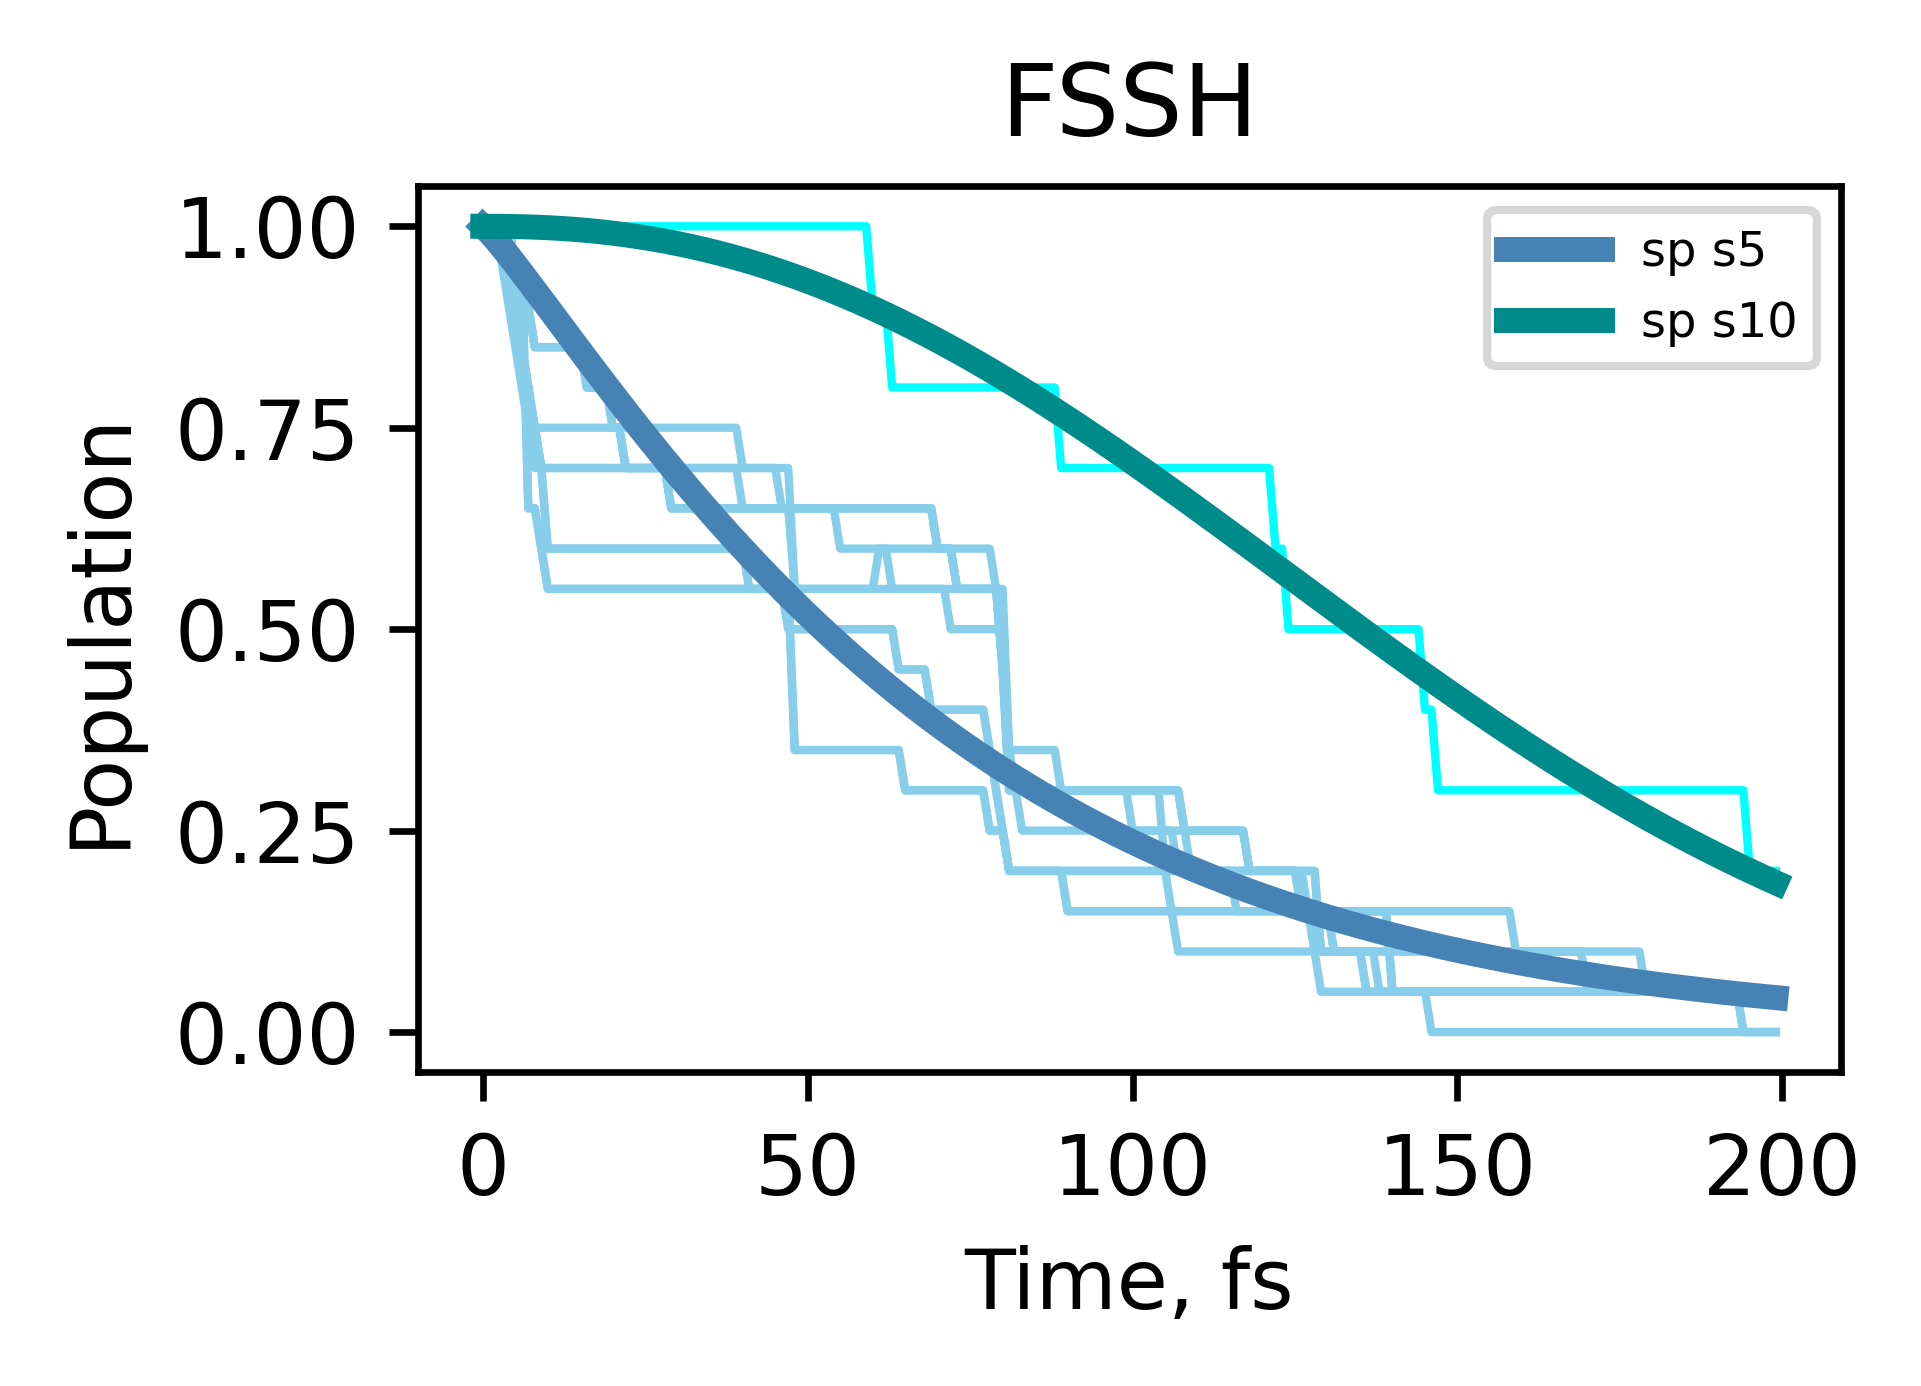

------------IDA----------
Folder = ./results/namd_regular_sd-5/_start_s10_IDA_batch0
tau: 45.84313787566334  beta: 0.5556493265186222  R2: 0.873045010214689
Folder = ./results/namd_regular_sd-5/_start_s10_IDA_batch2
tau: 73.07287590731966  beta: 1.0176935552817752  R2: 0.8862105631873176
Folder = ./results/namd_regular_sd-5/_start_s10_IDA_batch1
tau: 49.36883400143166  beta: 0.7622909967816752  R2: 0.9555859810711004
Folder = ./results/namd_regular_sd-5/_start_s10_IDA_batch5
tau: 85.18423734742682  beta: 1.2796586919475808  R2: 0.92029243103347
Folder = ./results/namd_regular_sd-5/_start_s10_IDA_batch3
tau: 85.18423734742682  beta: 1.2796586919475808  R2: 0.92029243103347
Folder = ./results/namd_regular_sd-5/_start_s10_IDA_batch4
tau: 124.713647564602  beta: 1.2208354639760746  R2: 0.9059278847897295
Folder = ./results/namd_regular_sd-5/_start_s10_IDA_batch6
tau: 124.713647564602  beta: 1.2208354639760746  R2: 0.9059278847897295
Folder = ./results/namd_regular_sd-5/_start_s10_IDA_batch

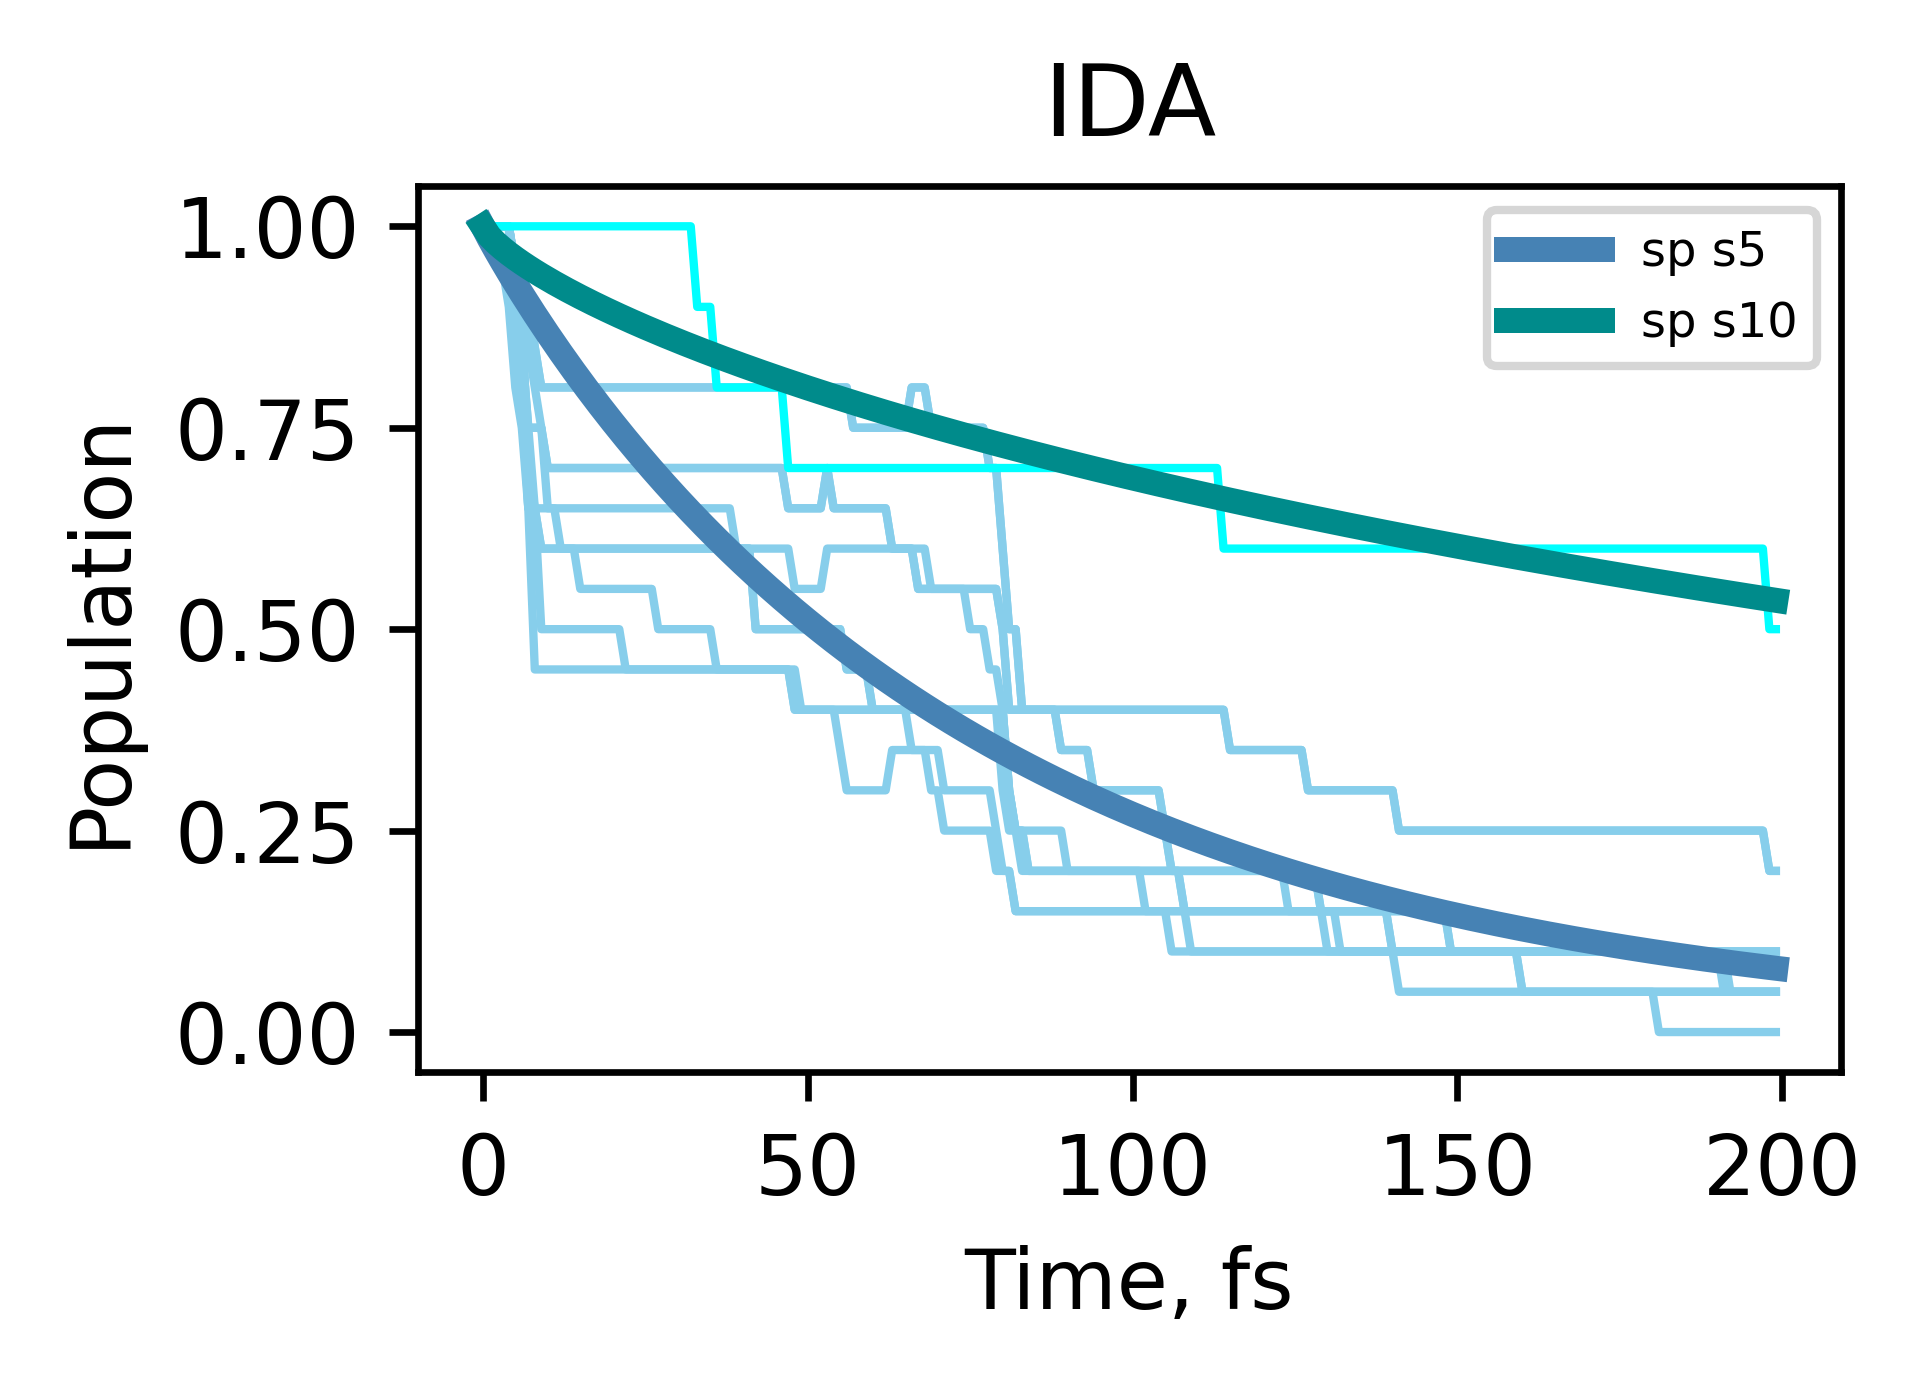

------------mSDM----------
Folder = ./results/namd_regular_sd-5/_start_s10_mSDM_batch1
tau: 40.364081825717626  beta: 0.7184761921149584  R2: 0.9424622820688106
Folder = ./results/namd_regular_sd-5/_start_s10_mSDM_batch0
tau: 51.61815852922296  beta: 0.8751100062882394  R2: 0.9089195645281346
Folder = ./results/namd_regular_sd-5/_start_s10_mSDM_batch2
tau: 79.46117396618479  beta: 1.5638006245990417  R2: 0.9396126179841922
Folder = ./results/namd_regular_sd-5/_start_s10_mSDM_batch4
tau: 79.46117396618479  beta: 1.5638006245990417  R2: 0.9396126179841922
Folder = ./results/namd_regular_sd-5/_start_s10_mSDM_batch3
tau: 73.14602077468398  beta: 0.7724172165471068  R2: 0.8750298197356373
Folder = ./results/namd_regular_sd-5/_start_s10_mSDM_batch5
tau: 73.14602077468398  beta: 0.7724172165471068  R2: 0.8750298197356373
Folder = ./results/namd_regular_sd-5/_start_s10_mSDM_batch6
tau: 77.43000840433152  beta: 1.110969106229763  R2: 0.9609996257514963
Folder = ./results/namd_regular_sd-5/_star

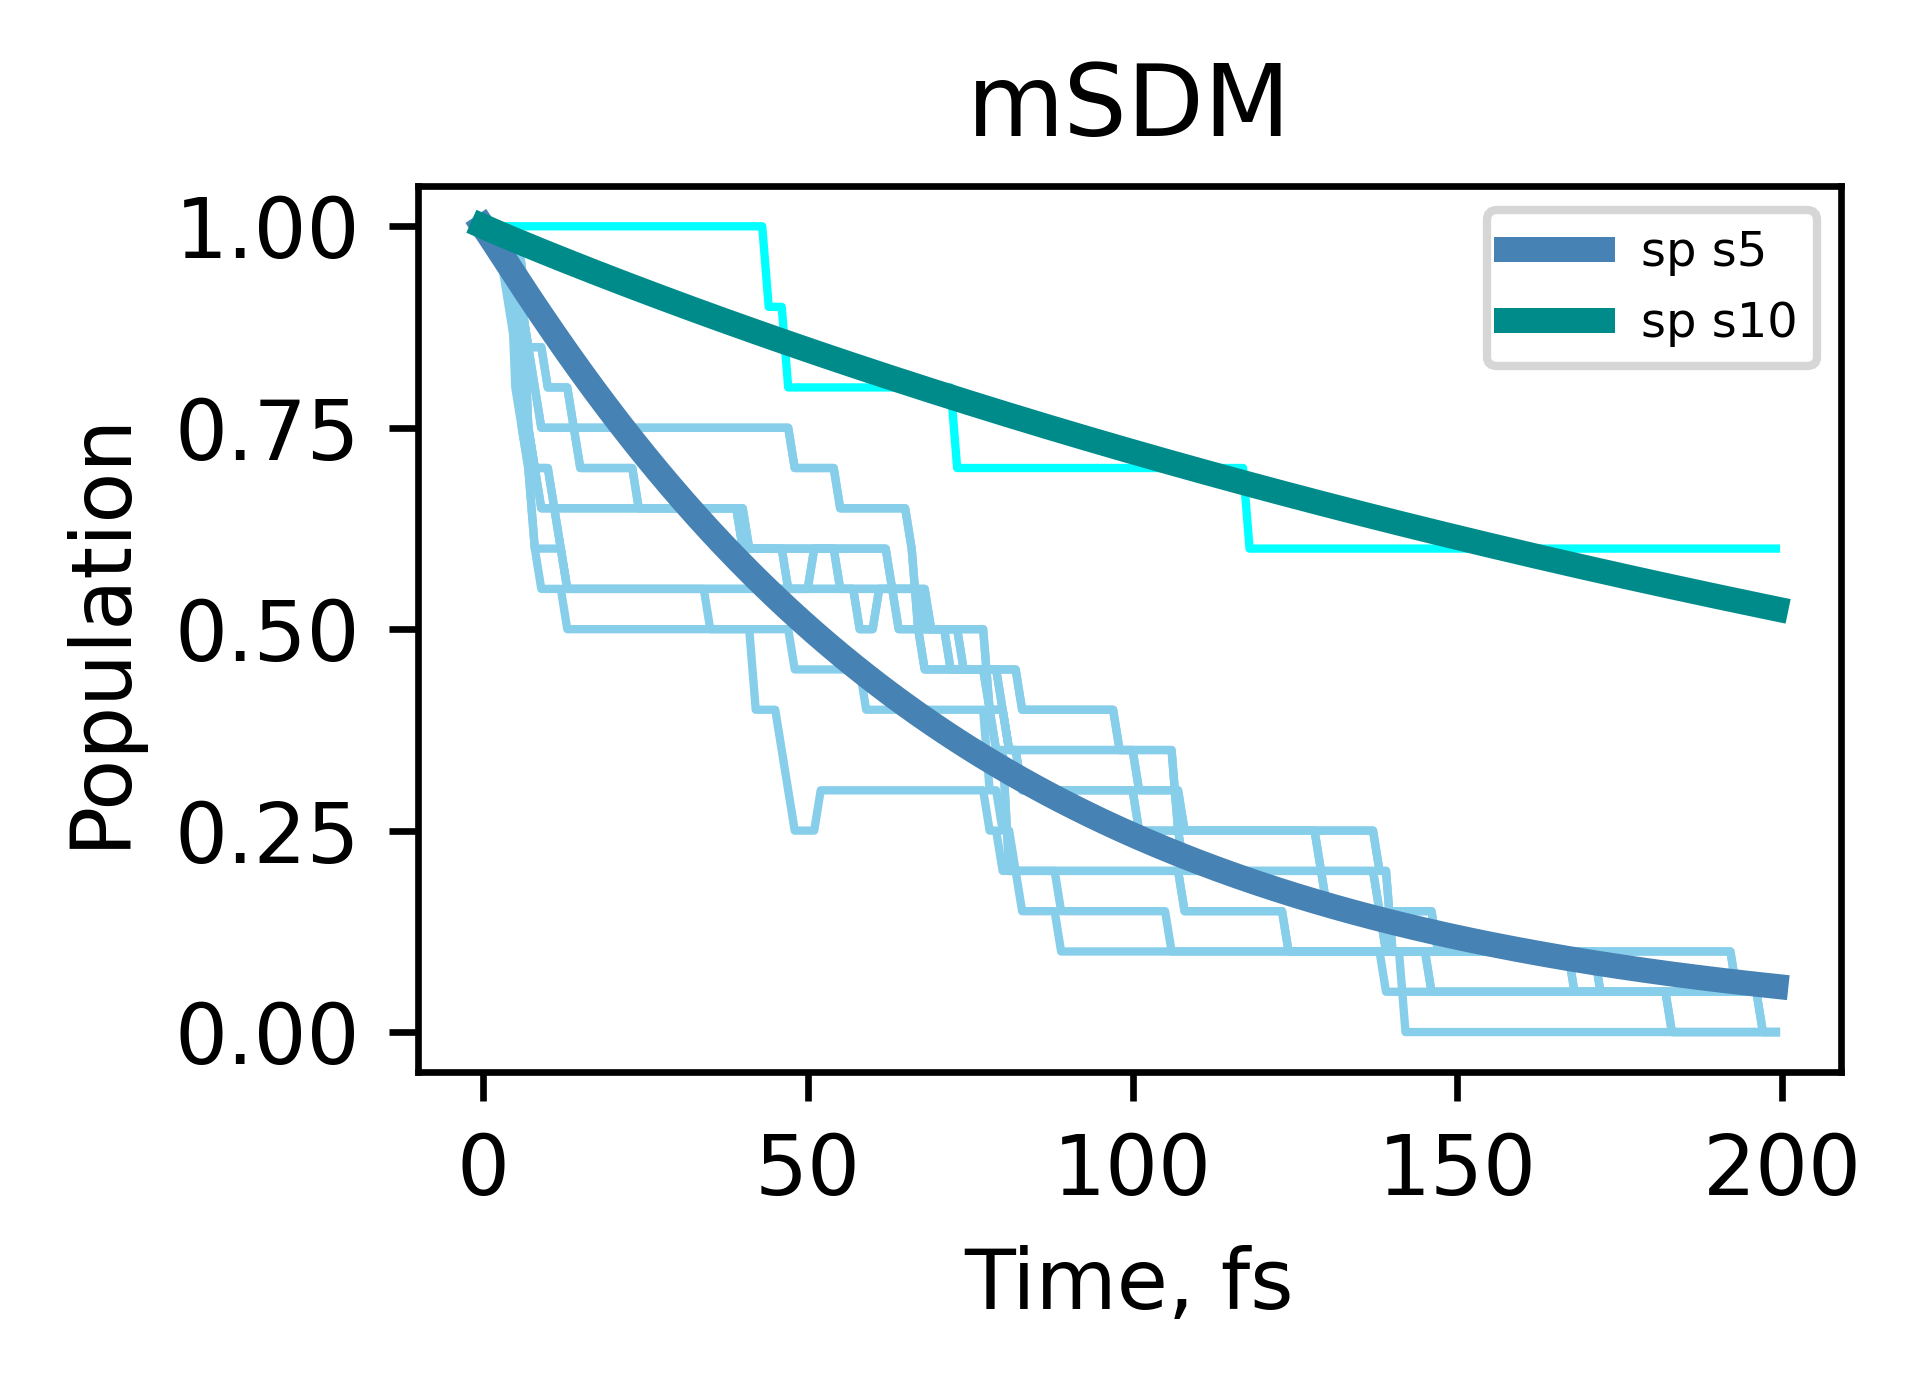

In [11]:
%matplotlib inline
#notebook
#figure = plt.figure(num=None, figsize=(3.21, 2.41), dpi=300, edgecolor='black', frameon=True)        

def stretched_compressed(t, tau, beta):
    return np.exp( -np.power(( t/tau ),beta) )

for c, scheme in enumerate(['FSSH', 'IDA','mSDM']):
    figure = plt.figure(num=None, figsize=(3.21, 2.41), dpi=600, edgecolor='black', frameon=True)
    print(F'------------{scheme}----------')
    #plt.subplot(1,2,c+1)
    folders = glob.glob(F'./results/namd_regular_sd-5/_start_s10_{scheme}_batch*', recursive = True)
    taus = []
    betas = []
    
    for folder in folders:
        
        print("Folder =", folder)
        sh_pop = np.loadtxt(folder+'/SH_pop.txt')
        sh_pop_hot_state = sh_pop[:,10]
        md_time = np.arange(0, sh_pop_hot_state.shape[0], 1.0)
        popt, pcov = curve_fit( stretched_compressed, md_time, sh_pop_hot_state, 
                                   bounds=([0.0, 0.0],[np.inf, np.inf]))
        tau, beta = popt
        # Computing the R-squared
        residuals  = sh_pop_hot_state - stretched_compressed(md_time, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop_hot_state - np.mean(sh_pop_hot_state))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        print('tau:', tau, ' beta:', beta,' R2:', r_squared)
        
        if r_squared>0.01:
            taus.append(tau)
            betas.append(beta)
            plt.plot(md_time, sh_pop_hot_state,  linewidth=1, color = "skyblue")
            
    ave_tau = np.average(np.array(taus))
    ave_beta = np.average(np.array(betas))
    # Compute the erro bars
    # The confidence interval
    Z = 1.96
    N = len(taus)
    s = np.std(np.array(taus))
    error_bar = Z*s/np.sqrt(N)
    
######################################################################################################################        
    
    
  # folders2 = glob.glob(F'./results/namd_regular_mb-Hvib_sd/_start_s10_{scheme}_batch*', recursive = True)
  # taus2 = []
  # betas2 = []    
  # for folder in folders2:
  #     
  #     print("Folder =", folder)
  #     sh_pop = np.loadtxt(folder+'/SH_pop.txt')
  #     sh_pop_hot_state = sh_pop[:,10]
  #     md_time2 = np.arange(0, sh_pop_hot_state.shape[0], 1.0)
  #     popt, pcov = curve_fit( stretched_compressed, md_time2, sh_pop_hot_state, 
  #                                bounds=([0.0, 0.0],[np.inf, np.inf]))
  #     tau, beta = popt
  #     # Computing the R-squared
  #     residuals  = sh_pop_hot_state - stretched_compressed(md_time2, *popt)
  #     ss_res     = np.sum(residuals**2)
  #     ss_tot     = np.sum((sh_pop_hot_state - np.mean(sh_pop_hot_state))**2)
  #     r_squared  = 1.0 - (ss_res / ss_tot)
  #     print('tau:', tau, ' beta:', beta,' R2:', r_squared)
  #     
  #     if r_squared>0.01:
  #         taus2.append(tau)
  #         betas2.append(beta)
  #         plt.plot(md_time2, sh_pop_hot_state,  linewidth=1, color = "pink")
  #         
  # ave_tau2 = np.average(np.array(taus2))
  # ave_beta2 = np.average(np.array(betas2))
  # # Compute the erro bars
  # # The confidence interval
  # Z = 1.96
  # N = len(taus2)
  # s = np.std(np.array(taus2))
  # error_bar = Z*s/np.sqrt(N)
    
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
     
    folders3 = glob.glob(F'./results/namd_regular_sd-10/_start_s10_{scheme}_batch*', recursive = True)
    taus3 = []
    betas3 = []    
    for folder in folders3:
        
        print("Folder =", folder)
        sh_pop = np.loadtxt(folder+'/SH_pop.txt')
        sh_pop_hot_state = sh_pop[:,10]
        md_time3 = np.arange(0, sh_pop_hot_state.shape[0], 1.0)
        popt, pcov = curve_fit( stretched_compressed, md_time3, sh_pop_hot_state, 
                                   bounds=([0.0, 0.0],[np.inf, np.inf]))
        tau, beta = popt
        # Computing the R-squared
        residuals  = sh_pop_hot_state - stretched_compressed(md_time3, *popt)
        ss_res     = np.sum(residuals**2)
        ss_tot     = np.sum((sh_pop_hot_state - np.mean(sh_pop_hot_state))**2)
        r_squared  = 1.0 - (ss_res / ss_tot)
        print('tau:', tau, ' beta:', beta,' R2:', r_squared)
        
        if r_squared>0.01:
            taus3.append(tau)
            betas3.append(beta)
            plt.plot(md_time3, sh_pop_hot_state,  linewidth=1, color = "aqua")
            
    ave_tau3 = np.average(np.array(taus3))
    ave_beta3 = np.average(np.array(betas3))
    # Compute the erro bars
    # The confidence interval
    Z = 1.96
    N = len(taus3)
    s = np.std(np.array(taus3))
    error_bar = Z*s/np.sqrt(N)
######################################################################################################################        

       
    print(F'The timescales: {ave_tau}+-{error_bar} average over {len(taus)} samples')
    # Plot average fit
    #plt.plot(md_time, stretched_compressed(md_time, ave_tau-error_bar, ave_beta), ls='--',linewidth=3, color='red')
    plt.plot(md_time, stretched_compressed(md_time, ave_tau,           ave_beta), ls='-',  linewidth=3,label='sp s5', color='steelblue')
    #plt.plot(md_time2, stretched_compressed(md_time2, ave_tau2,           ave_beta2), ls='-',  linewidth=3,label='MB sd', color='maroon')
    plt.plot(md_time3, stretched_compressed(md_time3, ave_tau3,           ave_beta3), ls='-',  linewidth=3,label='sp s10', color='darkcyan')

    #plt.plot(md_time, stretched_compressed(md_time, ave_tau+error_bar, ave_beta), ls='--', linewidth=3, color='red')
    plt.legend(fontsize=5.75, ncol=1, loc='upper right')
    plt.title(scheme)
    plt.xlabel('Time, fs')
    plt.ylabel('Population')
    plt.tight_layout()
    plt.savefig(F'./results/{scheme}-sd_mb.png', dpi=600)
    plt.show() 